# Reading IcePod in Python

In [1]:
import os
import xarray as xr
import numpy as np
import dask.array as dsa
from scipy.io import loadmat

### Data Location
This depends on the system where the data is stored of course.

In [2]:
ddir = '/data/scratch/rpa/icepod/wonder.ldeo.columbia.edu/wordpress/wp-data/pangeo_sir'
fname = 'AN03_F1003_20161124_235607_level1_SIR.mat'

### Read Matlab Data

This uses scipy's [`loadmat`](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.io.loadmat.html#scipy.io.loadmat) function to read the data.

Note that `loadmat` is *not* lazy. It eagerly loads everything into memory as numpy arrays. Therefore this is a good long-term solution for working with this dataset. Workarounds could be possible, but ultimately the data should be converted to HDF5 or netCDF4.

In [3]:
%time data = loadmat(os.path.join(ddir, fname), squeeze_me=True)

CPU times: user 12.7 s, sys: 1.41 s, total: 14.1 s
Wall time: 14.1 s


In [4]:
list(data.keys())

['__header__',
 '__version__',
 '__globals__',
 'numCohAvg',
 'NFFTr',
 'InRange',
 'tsamp',
 'tau',
 'FlightNo',
 'numexcessFrames',
 'echotimeutc',
 'numfftAvg',
 'radecho',
 'sirPwrOut',
 'filesinbatch',
 'txOn',
 'lat',
 'lon',
 'hell',
 'pitch',
 'roll',
 'heading',
 'Campaign',
 'twtt',
 'fbins',
 'fs',
 'Range',
 'prodLevel',
 'layerInd']

### Try to guess relationships between variables

These `.mat` files are *not* self describing. There are clearly relationships between the different variables, but these relationship are not encoded directly in the `.mat` file. Richer formats like netCDF or HDF allow metadata to be attached. For now I just make some informed guesses about these relationships based on data shape.

In [5]:
# just my guess about coordinates
dim_names = ('Range', 'echotimeutc')
coords = {key: data[key] for key in dim_names}
# add a layer coord
coords['layer'] = [0, 1]
coord_lens = {len(val): key for key, val in coords.items()}
coord_lens

{2: 'layer', 3751: 'echotimeutc', 14497: 'Range'}

In [6]:
# a function to infer the dimensions of the data based on shape
def guess_dims(key, array):
    try:
        dims = [coord_lens[s] for s in array.shape]
        return dims, array
    except (KeyError, AttributeError):
        return key, np.atleast_1d(array)

### Convert to xarray Dataset

In [7]:
data_vars = {key: guess_dims(key, val)
             for key, val in data.items()
             if not (key.startswith('__') or key in coords)}

In [8]:
# load into xarray data structure
ds = xr.Dataset(data_vars, coords)
ds

<xarray.Dataset>
Dimensions:          (Campaign: 1, FlightNo: 1, NFFTr: 1, Range: 14497, echotimeutc: 3751, filesinbatch: 6, fs: 1, layer: 2, numCohAvg: 1, numexcessFrames: 1, numfftAvg: 1, tau: 1, tsamp: 11251, twtt: 16385)
Coordinates:
  * numCohAvg        (numCohAvg) int64 4
  * NFFTr            (NFFTr) int64 32768
  * tsamp            (tsamp) float64 1.498e-05 1.5e-05 1.502e-05 1.504e-05 ...
  * tau              (tau) float64 0.00025
  * FlightNo         (FlightNo) <U5 'F1003'
  * numexcessFrames  (numexcessFrames) int64 0
  * numfftAvg        (numfftAvg) int64 1
  * filesinbatch     (filesinbatch) [('name', 'O'), ('date', 'O'), ('bytes', 'O'), ('isdir', 'O'), ('datenum', 'O'), ('utc', 'O')] ('AN03_F1003_20161124_235608_0390.sir', '24-Nov-2016 18:56:18', 124740000, 0, 736658.7890972223, 1480031768.0000012) ...
  * Campaign         (Campaign) <U4 'AN03'
  * twtt             (twtt) float64 0.0 6.356e-10 1.271e-09 1.907e-09 ...
  * fs               (fs) int64 50000000
  * Range       

### Visulize with Bokeh


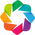

In [9]:
import holoviews as hv
from holoviews.operation.datashader import datashade, regrid
hv.extension('bokeh')

In [10]:
hvds = hv.Dataset(np.log10(abs(ds.radecho)))

In [11]:
%%opts Image [height=400 width=900]
regrid(hvds.to(hv.Image))

:DynamicMap   []